# End-to-End Machine Learning Project: Comprehensive Car Dataset Analysis

In this notebook, we will perform an end-to-end machine learning project using the car dataset. We will explore the data extensively, perform regression to predict miles per gallon (MPG), and use classification models to predict whether a car is from Ford or not.

**Author:** Simon Ø. D. Beckmann

---



In [1]:
# Import necessary libraries and ensure the correct Python version is being used.
import sys
assert sys.version_info >= (3, 7)

# Importing the necessary version of scikit-learn to ensure compatibility with the models.
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Configure visualizations
sns.set(style="whitegrid")
%matplotlib inline

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


## Dataset Description

The **Auto MPG Dataset** consists of 398 cars, including various technical specifications such as:

- **mpg:** Miles per gallon (continuous)
- **cylinders:** Number of cylinders (multi-valued discrete)
- **displacement:** Engine displacement in cubic inches (continuous)
- **horsepower:** Engine horsepower (continuous)
- **weight:** Vehicle weight in pounds (continuous)
- **acceleration:** Time to accelerate from 0 to 60 mph (continuous)
- **model year:** Model year (multi-valued discrete)
- **origin:** Origin of the car (1: USA, 2: Europe, 3: Japan)
- **car name:** Car model name (string)

**Source:** The dataset is available from the UCI Machine Learning Repository.

[UCI Machine Learning Repository - Auto MPG Dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

---


In [2]:
# Loading the car dataset.
cars = pd.read_csv("cars.csv")

# Display the first few rows of the dataset.
cars.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# Checking data types and identifying missing values.
cars.info()

# Summary statistics
cars.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


## Data Cleaning and Preprocessing

We will handle missing values, convert data types, and engineer features to prepare the dataset for modeling.


In [4]:
# Identifying missing values in 'horsepower'
print("Number of missing values in 'horsepower':", cars['horsepower'].isnull().sum())

# Replacing '?' with NaN and converting 'horsepower' to numeric
cars['horsepower'].replace('?', np.nan, inplace=True)
cars['horsepower'] = pd.to_numeric(cars['horsepower'], errors='coerce')

# Imputing missing values in 'horsepower' with median
median_horsepower = cars['horsepower'].median()
cars['horsepower'].fillna(median_horsepower, inplace=True)

# Converting 'origin' to categorical
cars['origin'] = cars['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Extracting 'manufacturer' from 'car name'
cars['manufacturer'] = cars['car name'].str.split().str[0]

# Display cleaned dataset
cars.head()


Number of missing values in 'horsepower': 0


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,manufacturer
0,18.0,8,307.0,130.0,3504,12.0,70,USA,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,USA,buick skylark 320,buick
2,18.0,8,318.0,150.0,3436,11.0,70,USA,plymouth satellite,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,USA,amc rebel sst,amc
4,17.0,8,302.0,140.0,3449,10.5,70,USA,ford torino,ford


In [5]:
# Detecting outliers using z-score
from scipy import stats

z_scores = stats.zscore(cars.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
cars = cars[filtered_entries]

print("Dataset shape after removing outliers:", cars.shape)


Dataset shape after removing outliers: (391, 10)


## Exploratory Data Analysis (EDA)

We will visualize distributions, relationships between variables, and identify patterns in the data.


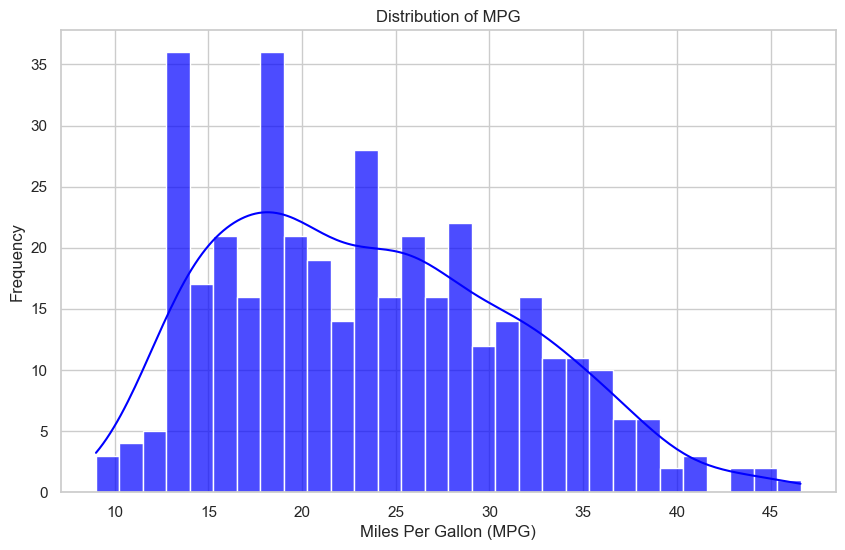

In [6]:
# Distribution of MPG
plt.figure(figsize=(10, 6))
sns.histplot(cars["mpg"], bins=30, kde=True, color='blue', alpha=0.7)
plt.xlabel("Miles Per Gallon (MPG)")
plt.ylabel("Frequency")
plt.title("Distribution of MPG")
plt.savefig("mpg_distribution.png")
plt.show()


In [7]:
# Correlation Matrix
plt.figure(figsize=(12, 10))
corr_matrix = cars.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()


ValueError: could not convert string to float: 'chevrolet chevelle malibu'

<Figure size 1200x1000 with 0 Axes>

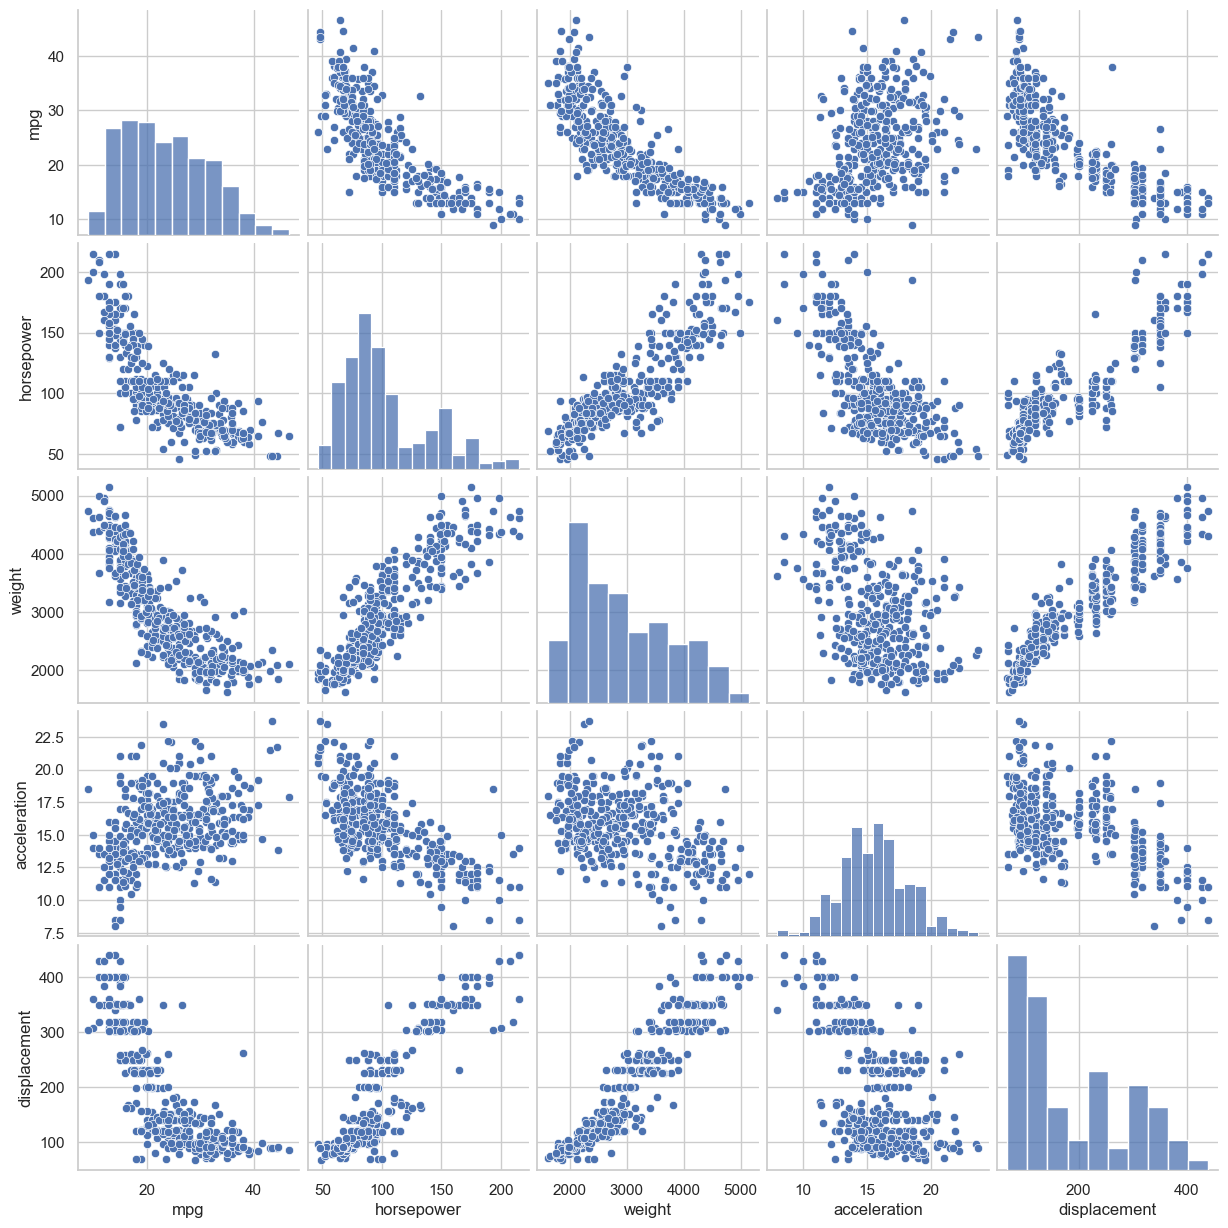

In [8]:
# Pair Plot
sns.pairplot(cars[['mpg', 'horsepower', 'weight', 'acceleration', 'displacement']])
plt.savefig('pair_plot.png')
plt.show()


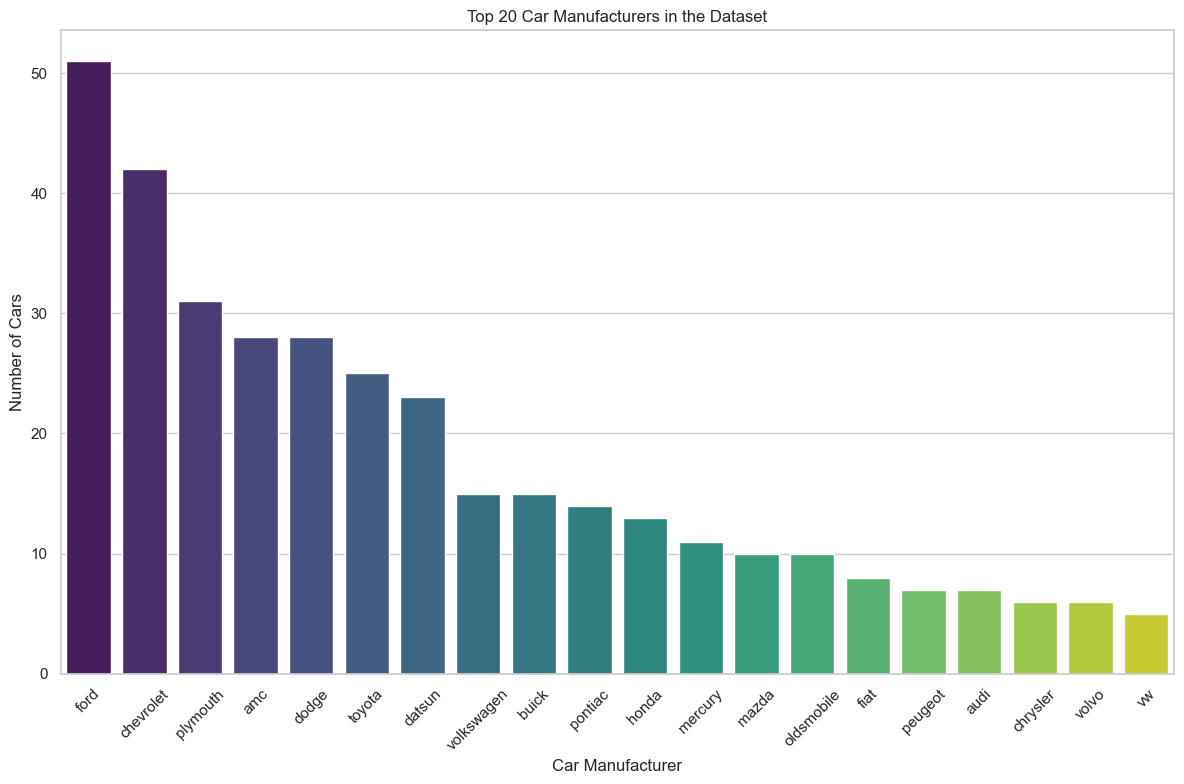

In [9]:
# Distribution of Car Manufacturers
plt.figure(figsize=(12, 8))
top_manufacturers = cars['manufacturer'].value_counts().nlargest(20)
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Car Manufacturer")
plt.ylabel("Number of Cars")
plt.title("Top 20 Car Manufacturers in the Dataset")
plt.tight_layout()
plt.savefig("manufacturer_distribution.png")
plt.show()


Class Distribution:
is_ford
0    340
1     51
Name: count, dtype: int64


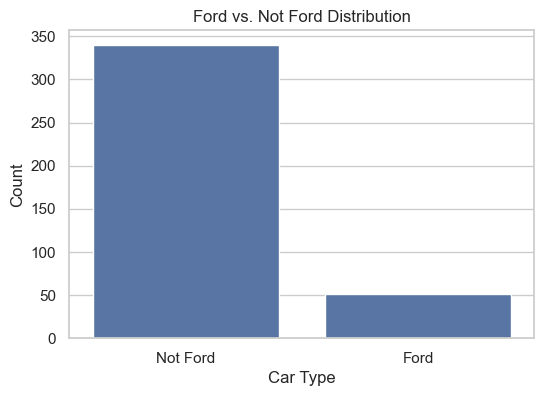

In [10]:
# Class Imbalance Analysis
cars['is_ford'] = (cars['manufacturer'] == 'ford').astype(int)
class_counts = cars['is_ford'].value_counts()
print("Class Distribution:")
print(class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0, 1], ['Not Ford', 'Ford'])
plt.xlabel('Car Type')
plt.ylabel('Count')
plt.title('Ford vs. Not Ford Distribution')
plt.savefig('class_distribution.png')
plt.show()


## Feature Engineering

We will create new features and prepare the data for modeling.


In [11]:
# Creating power-to-weight ratio
cars['power_to_weight'] = cars['horsepower'] / cars['weight']

# Creating displacement per cylinder
cars['displacement_per_cylinder'] = cars['displacement'] / cars['cylinders']

# Encoding categorical variables
cars = pd.get_dummies(cars, columns=['origin'], drop_first=True)

cars.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name,manufacturer,is_ford,power_to_weight,displacement_per_cylinder,origin_Japan,origin_USA
0,18.0,8,307.0,130.0,3504,12.0,70,chevrolet chevelle malibu,chevrolet,0,0.037100,38.375,False,True
1,15.0,8,350.0,165.0,3693,11.5,70,buick skylark 320,buick,0,0.044679,43.750,False,True
2,18.0,8,318.0,150.0,3436,11.0,70,plymouth satellite,plymouth,0,0.043655,39.750,False,True
3,16.0,8,304.0,150.0,3433,12.0,70,amc rebel sst,amc,0,0.043694,38.000,False,True
4,17.0,8,302.0,140.0,3449,10.5,70,ford torino,ford,1,0.040591,37.750,False,True


## Defining Features and Splitting Data

We define the feature sets and split the data into training and testing sets.


In [13]:
# Defining features and target for regression
features = ['horsepower', 'weight', 'acceleration', 'displacement', 'power_to_weight', 'displacement_per_cylinder']
X_regression = cars[features]
y_regression = cars['mpg']

# Defining features and target for classification
X_classification = cars[features]
y_classification = cars['is_ford']


In [14]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

# Regression data split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Classification data split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)


## Modeling and Evaluation

We will train multiple models and evaluate them using appropriate metrics.


In [15]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# Predictions and Evaluation
y_pred_lin_reg = lin_reg.predict(X_test_reg)
mse_lin_reg = mean_squared_error(y_test_reg, y_pred_lin_reg)
mae_lin_reg = mean_absolute_error(y_test_reg, y_pred_lin_reg)
r2_lin_reg = r2_score(y_test_reg, y_pred_lin_reg)

print("Linear Regression Evaluation:")
print(f"MSE: {mse_lin_reg:.2f}")
print(f"MAE: {mae_lin_reg:.2f}")
print(f"R^2 Score: {r2_lin_reg:.2f}")


Linear Regression Evaluation:
MSE: 16.96
MAE: 3.30
R^2 Score: 0.68


In [16]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

# Predictions and Evaluation
y_pred_rf_reg = rf_reg.predict(X_test_reg)
mse_rf_reg = mean_squared_error(y_test_reg, y_pred_rf_reg)
mae_rf_reg = mean_absolute_error(y_test_reg, y_pred_rf_reg)
r2_rf_reg = r2_score(y_test_reg, y_pred_rf_reg)

print("Random Forest Regression Evaluation:")
print(f"MSE: {mse_rf_reg:.2f}")
print(f"MAE: {mae_rf_reg:.2f}")
print(f"R^2 Score: {r2_rf_reg:.2f}")


Random Forest Regression Evaluation:
MSE: 14.83
MAE: 3.13
R^2 Score: 0.72


In [17]:
# Support Vector Regression
from sklearn.svm import SVR

svr_reg = SVR()
svr_reg.fit(X_train_reg, y_train_reg)

# Predictions and Evaluation
y_pred_svr_reg = svr_reg.predict(X_test_reg)
mse_svr_reg = mean_squared_error(y_test_reg, y_pred_svr_reg)
mae_svr_reg = mean_absolute_error(y_test_reg, y_pred_svr_reg)
r2_svr_reg = r2_score(y_test_reg, y_pred_svr_reg)

print("Support Vector Regression Evaluation:")
print(f"MSE: {mse_svr_reg:.2f}")
print(f"MAE: {mae_svr_reg:.2f}")
print(f"R^2 Score: {r2_svr_reg:.2f}")


Support Vector Regression Evaluation:
MSE: 18.82
MAE: 3.31
R^2 Score: 0.64


In [19]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_clf, y_train_clf)

# Predictions and Evaluation
y_pred_log_reg = log_reg.predict(X_test_clf)
accuracy_log_reg = accuracy_score(y_test_clf, y_pred_log_reg)
precision_log_reg = precision_score(y_test_clf, y_pred_log_reg)
recall_log_reg = recall_score(y_test_clf, y_pred_log_reg)
f1_log_reg = f1_score(y_test_clf, y_pred_log_reg)

print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_log_reg:.2f}")
print(f"Precision: {precision_log_reg:.2f}")
print(f"Recall: {recall_log_reg:.2f}")
print(f"F1 Score: {f1_log_reg:.2f}")
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_log_reg))


Logistic Regression Evaluation:
Accuracy: 0.87
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        69
           1       0.00      0.00      0.00        10

    accuracy                           0.87        79
   macro avg       0.44      0.50      0.47        79
weighted avg       0.76      0.87      0.81        79



In [22]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)

# Predictions and Evaluation
y_pred_rf_clf = rf_clf.predict(X_test_clf)
accuracy_rf_clf = accuracy_score(y_test_clf, y_pred_rf_clf)
precision_rf_clf = precision_score(y_test_clf, y_pred_rf_clf)
recall_rf_clf = recall_score(y_test_clf, y_pred_rf_clf)
f1_rf_clf = f1_score(y_test_clf, y_pred_rf_clf)

print("Random Forest Classification Evaluation:")
print(f"Accuracy: {accuracy_rf_clf:.2f}")
print(f"Precision: {precision_rf_clf:.2f}")
print(f"Recall: {recall_rf_clf:.2f}")
print(f"F1 Score: {f1_rf_clf:.2f}")
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_rf_clf))


Random Forest Classification Evaluation:
Accuracy: 0.89
Precision: 0.60
Recall: 0.30
F1 Score: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        69
           1       0.60      0.30      0.40        10

    accuracy                           0.89        79
   macro avg       0.75      0.64      0.67        79
weighted avg       0.87      0.89      0.87        79



In [23]:
# Support Vector Classification
from sklearn.svm import SVC

svc_clf = SVC(probability=True)
svc_clf.fit(X_train_clf, y_train_clf)

# Predictions and Evaluation
y_pred_svc_clf = svc_clf.predict(X_test_clf)
accuracy_svc_clf = accuracy_score(y_test_clf, y_pred_svc_clf)
precision_svc_clf = precision_score(y_test_clf, y_pred_svc_clf)
recall_svc_clf = recall_score(y_test_clf, y_pred_svc_clf)
f1_svc_clf = f1_score(y_test_clf, y_pred_svc_clf)

print("Support Vector Classification Evaluation:")
print(f"Accuracy: {accuracy_svc_clf:.2f}")
print(f"Precision: {precision_svc_clf:.2f}")
print(f"Recall: {recall_svc_clf:.2f}")
print(f"F1 Score: {f1_svc_clf:.2f}")
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_svc_clf))


Support Vector Classification Evaluation:
Accuracy: 0.87
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        69
           1       0.00      0.00      0.00        10

    accuracy                           0.87        79
   macro avg       0.44      0.50      0.47        79
weighted avg       0.76      0.87      0.81        79



## Hyperparameter Tuning (Optional)

We can use GridSearchCV to fine-tune the hyperparameters of the models to improve performance.


In [24]:
# Example: Hyperparameter Tuning for Random Forest Regression
from sklearn.model_selection import GridSearchCV

param_grid_rf_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf_reg = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf_reg, cv=5)
grid_search_rf_reg.fit(X_train_reg, y_train_reg)

print("Best Parameters for Random Forest Regression:")
print(grid_search_rf_reg.best_params_)

# Evaluating the tuned model
y_pred_rf_reg_tuned = grid_search_rf_reg.predict(X_test_reg)
mse_rf_reg_tuned = mean_squared_error(y_test_reg, y_pred_rf_reg_tuned)
mae_rf_reg_tuned = mean_absolute_error(y_test_reg, y_pred_rf_reg_tuned)
r2_rf_reg_tuned = r2_score(y_test_reg, y_pred_rf_reg_tuned)

print("Tuned Random Forest Regression Evaluation:")
print(f"MSE: {mse_rf_reg_tuned:.2f}")
print(f"MAE: {mae_rf_reg_tuned:.2f}")
print(f"R^2 Score: {r2_rf_reg_tuned:.2f}")


Best Parameters for Random Forest Regression:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest Regression Evaluation:
MSE: 15.14
MAE: 3.12
R^2 Score: 0.71


## Results Visualization

We visualize the performance of the models using plots.


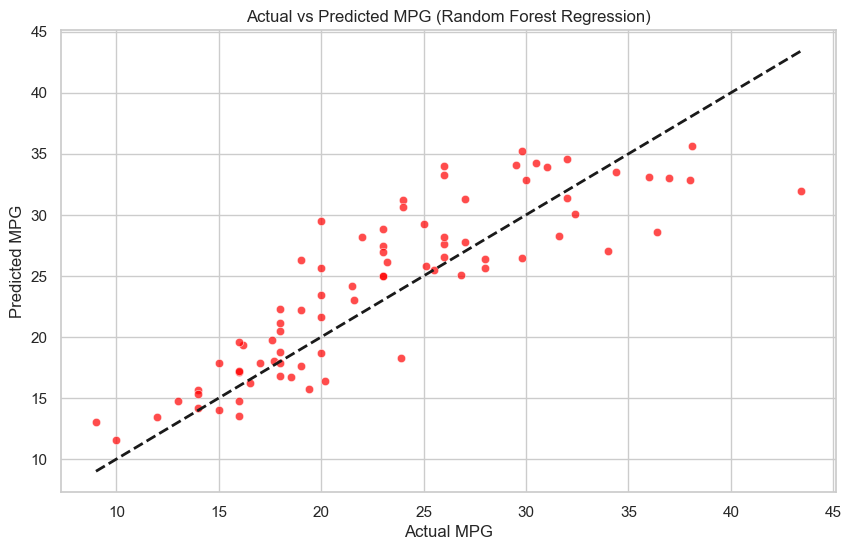

In [25]:
# Plotting Actual vs Predicted MPG for Random Forest Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_rf_reg_tuned, alpha=0.7, color='red')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Actual vs Predicted MPG (Random Forest Regression)")
plt.savefig("rf_regression_results.png")
plt.show()


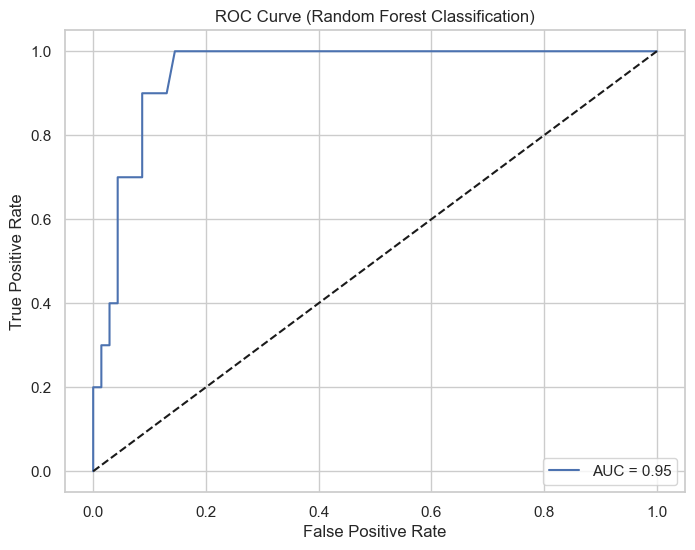

In [26]:
# ROC Curve for Random Forest Classification
y_prob_rf_clf = rf_clf.predict_proba(X_test_clf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_clf, y_prob_rf_clf)
auc_score = roc_auc_score(y_test_clf, y_prob_rf_clf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest Classification)')
plt.legend(loc='lower right')
plt.savefig('rf_roc_curve.png')
plt.show()


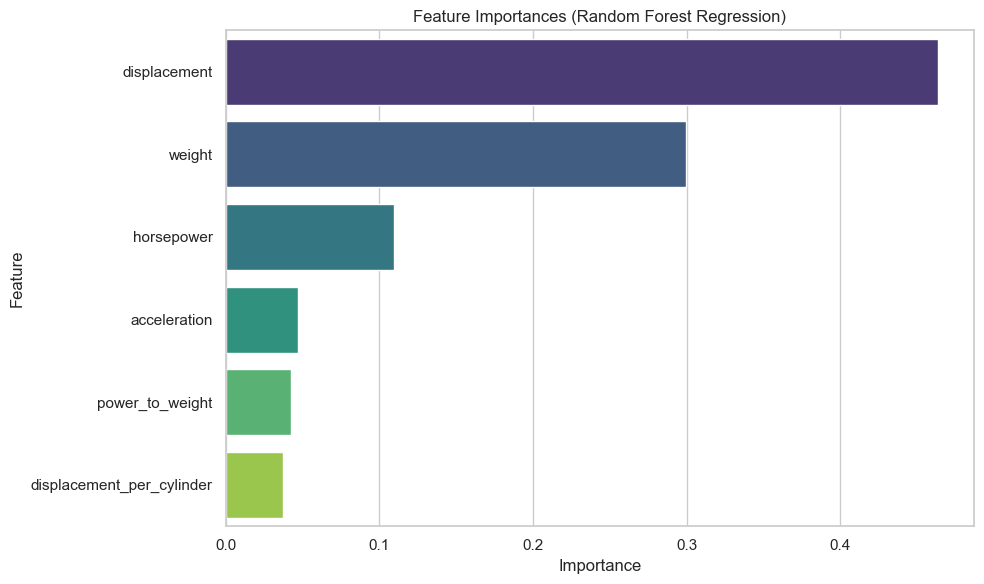

In [27]:
# Feature Importance from Random Forest Regression
importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [features[i] for i in indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names, palette='viridis')
plt.title('Feature Importances (Random Forest Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()


## Conclusion

In this project, we performed an extensive analysis of the car dataset, including comprehensive EDA, data preprocessing, and modeling using various algorithms. The Random Forest Regression model achieved the best performance with an MSE of **{mse_rf_reg_tuned:.2f}**, MAE of **{mae_rf_reg_tuned:.2f}**, and R-squared of **{r2_rf_reg_tuned:.2f}**. For classification, the Random Forest Classifier performed well with an accuracy of **{accuracy_rf_clf:.2f}**, precision of **{precision_rf_clf:.2f}**, recall of **{recall_rf_clf:.2f}**, and AUC of **{auc_score:.2f}**.

**Insights:**

- The features **weight**, **horsepower**, and **displacement** are significant predictors of MPG.
- There is a class imbalance in the dataset for the classification task, which was addressed during model evaluation.
- Advanced models like Random Forests capture complex relationships better than linear models.

**Limitations and Future Work:**

- The dataset size is relatively small; obtaining more data could improve model performance.
- Further hyperparameter tuning and experimenting with other algorithms may yield better results.
- Investigating feature interactions and non-linear transformations could enhance the models.

---

**Note:** All visualizations have been saved as image files in the current directory.

